In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(236358, 828)
(236358, 1)
validation
(44338, 828)
(44338, 1)
test
(22164, 828)
(22164, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/24 [>.............................] - ETA: 38s - loss: 0.1215 - STD: 2.0373e-04 - MAE: 0.3324

 3/24 [==>...........................] - ETA: 0s - loss: 0.0559 - STD: 3.9630e-04 - MAE: 0.1840 

 5/24 [=====>........................] - ETA: 0s - loss: 0.0498 - STD: 3.2984e-04 - MAE: 0.1715

 6/24 [======>.......................] - ETA: 0s - loss: 0.0492 - STD: 2.9704e-04 - MAE: 0.1710

 7/24 [=======>......................] - ETA: 0s - loss: 0.0486 - STD: 2.7013e-04 - MAE: 0.1703

 8/24 [=========>....................] - ETA: 0s - loss: 0.0476 - STD: 2.4900e-04 - MAE: 0.1680

 9/24 [==========>...................] - ETA: 0s - loss: 0.0464 - STD: 2.3334e-04 - MAE: 0.1647

10/24 [===========>..................] - ETA: 0s - loss: 0.0448 - STD: 2.2272e-04 - MAE: 0.1598

11/24 [============>.................] - ETA: 0s - loss: 0.0430 - STD: 2.1595e-04 - MAE: 0.1539

12/24 [==============>...............] - ETA: 0s - loss: 0.0410 - STD: 2.1210e-04 - MAE: 0.1475

13/24 [===============>..............] - ETA: 0s - loss: 0.0393 - STD: 2.0998e-04 - MAE: 0.1428

14/24 [================>.............] - ETA: 0s - loss: 0.0377 - STD: 2.0885e-04 - MAE: 0.1401

15/24 [=================>............] - ETA: 1s - loss: 0.0370 - STD: 2.0816e-04 - MAE: 0.1392

17/24 [====================>.........] - ETA: 0s - loss: 0.0355 - STD: 2.0724e-04 - MAE: 0.1395

19/24 [======================>.......] - ETA: 0s - loss: 0.0341 - STD: 2.0691e-04 - MAE: 0.1387

20/24 [========================>.....] - ETA: 0s - loss: 0.0334 - STD: 2.0688e-04 - MAE: 0.1374

21/24 [=========================>....] - ETA: 0s - loss: 0.0326 - STD: 2.0680e-04 - MAE: 0.1354

22/24 [==========================>...] - ETA: 0s - loss: 0.0319 - STD: 2.0672e-04 - MAE: 0.1333

23/24 [===========================>..] - ETA: 0s - loss: 0.0313 - STD: 2.0650e-04 - MAE: 0.1309

24/24 [==============================] - ETA: 0s - loss: 0.0308 - STD: 2.0633e-04 - MAE: 0.1287

24/24 [==============================] - 5s 135ms/step - loss: 0.0308 - STD: 2.0633e-04 - MAE: 0.1287 - val_loss: 0.0241 - val_STD: 1.8298e-04 - val_MAE: 0.0806


Epoch 2/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0199 - STD: 2.0409e-04 - MAE: 0.0775

 2/24 [=>............................] - ETA: 1s - loss: 0.0203 - STD: 2.0530e-04 - MAE: 0.0783

 3/24 [==>...........................] - ETA: 1s - loss: 0.0203 - STD: 2.0812e-04 - MAE: 0.0784

 4/24 [====>.........................] - ETA: 1s - loss: 0.0202 - STD: 2.1110e-04 - MAE: 0.0782

 5/24 [=====>........................] - ETA: 1s - loss: 0.0198 - STD: 2.1529e-04 - MAE: 0.0777

 6/24 [======>.......................] - ETA: 1s - loss: 0.0195 - STD: 2.2013e-04 - MAE: 0.0776

 8/24 [=========>....................] - ETA: 1s - loss: 0.0190 - STD: 2.3188e-04 - MAE: 0.0790

 9/24 [==========>...................] - ETA: 1s - loss: 0.0189 - STD: 2.3838e-04 - MAE: 0.0805

10/24 [===========>..................] - ETA: 1s - loss: 0.0188 - STD: 2.4465e-04 - MAE: 0.0822

11/24 [============>.................] - ETA: 1s - loss: 0.0187 - STD: 2.5148e-04 - MAE: 0.0841

12/24 [==============>...............] - ETA: 0s - loss: 0.0187 - STD: 2.5804e-04 - MAE: 0.0857

13/24 [===============>..............] - ETA: 0s - loss: 0.0187 - STD: 2.6466e-04 - MAE: 0.0873

14/24 [================>.............] - ETA: 0s - loss: 0.0187 - STD: 2.7118e-04 - MAE: 0.0887

15/24 [=================>............] - ETA: 0s - loss: 0.0187 - STD: 2.7733e-04 - MAE: 0.0895

16/24 [===================>..........] - ETA: 0s - loss: 0.0186 - STD: 2.8285e-04 - MAE: 0.0899

17/24 [====================>.........] - ETA: 0s - loss: 0.0185 - STD: 2.8824e-04 - MAE: 0.0899

18/24 [=====================>........] - ETA: 0s - loss: 0.0184 - STD: 2.9358e-04 - MAE: 0.0899

19/24 [======================>.......] - ETA: 0s - loss: 0.0184 - STD: 2.9878e-04 - MAE: 0.0897

20/24 [========================>.....] - ETA: 0s - loss: 0.0184 - STD: 3.0386e-04 - MAE: 0.0894

21/24 [=========================>....] - ETA: 0s - loss: 0.0184 - STD: 3.0896e-04 - MAE: 0.0891

22/24 [==========================>...] - ETA: 0s - loss: 0.0183 - STD: 3.1413e-04 - MAE: 0.0887

23/24 [===========================>..] - ETA: 0s - loss: 0.0183 - STD: 3.1975e-04 - MAE: 0.0884

24/24 [==============================] - ETA: 0s - loss: 0.0184 - STD: 3.2571e-04 - MAE: 0.0882

24/24 [==============================] - 2s 88ms/step - loss: 0.0184 - STD: 3.2571e-04 - MAE: 0.0882 - val_loss: 0.0215 - val_STD: 4.3412e-04 - val_MAE: 0.0891


Epoch 3/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0175 - STD: 4.7842e-04 - MAE: 0.0839

 2/24 [=>............................] - ETA: 2s - loss: 0.0176 - STD: 4.9496e-04 - MAE: 0.0848

 3/24 [==>...........................] - ETA: 1s - loss: 0.0174 - STD: 5.0751e-04 - MAE: 0.0855

 4/24 [====>.........................] - ETA: 1s - loss: 0.0174 - STD: 5.2100e-04 - MAE: 0.0868

 6/24 [======>.......................] - ETA: 1s - loss: 0.0173 - STD: 5.4873e-04 - MAE: 0.0886

 7/24 [=======>......................] - ETA: 1s - loss: 0.0175 - STD: 5.6394e-04 - MAE: 0.0897

 8/24 [=========>....................] - ETA: 1s - loss: 0.0175 - STD: 5.7752e-04 - MAE: 0.0902

 9/24 [==========>...................] - ETA: 1s - loss: 0.0175 - STD: 5.9121e-04 - MAE: 0.0907

10/24 [===========>..................] - ETA: 1s - loss: 0.0175 - STD: 6.0423e-04 - MAE: 0.0908

11/24 [============>.................] - ETA: 0s - loss: 0.0174 - STD: 6.1728e-04 - MAE: 0.0908

12/24 [==============>...............] - ETA: 0s - loss: 0.0174 - STD: 6.3057e-04 - MAE: 0.0906

13/24 [===============>..............] - ETA: 0s - loss: 0.0173 - STD: 6.4402e-04 - MAE: 0.0903

14/24 [================>.............] - ETA: 0s - loss: 0.0174 - STD: 6.5777e-04 - MAE: 0.0901

15/24 [=================>............] - ETA: 0s - loss: 0.0174 - STD: 6.7206e-04 - MAE: 0.0898

16/24 [===================>..........] - ETA: 0s - loss: 0.0175 - STD: 6.8800e-04 - MAE: 0.0896

17/24 [====================>.........] - ETA: 0s - loss: 0.0175 - STD: 7.0342e-04 - MAE: 0.0894

18/24 [=====================>........] - ETA: 0s - loss: 0.0175 - STD: 7.2085e-04 - MAE: 0.0893

19/24 [======================>.......] - ETA: 0s - loss: 0.0176 - STD: 7.3939e-04 - MAE: 0.0892

20/24 [========================>.....] - ETA: 0s - loss: 0.0176 - STD: 7.5909e-04 - MAE: 0.0892

21/24 [=========================>....] - ETA: 0s - loss: 0.0176 - STD: 7.7970e-04 - MAE: 0.0893

22/24 [==========================>...] - ETA: 0s - loss: 0.0176 - STD: 8.0118e-04 - MAE: 0.0893

23/24 [===========================>..] - ETA: 0s - loss: 0.0176 - STD: 8.2435e-04 - MAE: 0.0893

24/24 [==============================] - ETA: 0s - loss: 0.0176 - STD: 8.4841e-04 - MAE: 0.0894

24/24 [==============================] - 2s 86ms/step - loss: 0.0176 - STD: 8.4841e-04 - MAE: 0.0894 - val_loss: 0.0210 - val_STD: 0.0013 - val_MAE: 0.0974


Epoch 4/10000


 1/24 [>.............................] - ETA: 1s - loss: 0.0173 - STD: 0.0015 - MAE: 0.0914

 2/24 [=>............................] - ETA: 1s - loss: 0.0175 - STD: 0.0015 - MAE: 0.0916

 3/24 [==>...........................] - ETA: 1s - loss: 0.0175 - STD: 0.0016 - MAE: 0.0909

 4/24 [====>.........................] - ETA: 1s - loss: 0.0175 - STD: 0.0016 - MAE: 0.0906

 5/24 [=====>........................] - ETA: 1s - loss: 0.0173 - STD: 0.0017 - MAE: 0.0898

 6/24 [======>.......................] - ETA: 1s - loss: 0.0172 - STD: 0.0017 - MAE: 0.0891

 7/24 [=======>......................] - ETA: 1s - loss: 0.0171 - STD: 0.0018 - MAE: 0.0885

 8/24 [=========>....................] - ETA: 1s - loss: 0.0171 - STD: 0.0018 - MAE: 0.0881

 9/24 [==========>...................] - ETA: 1s - loss: 0.0171 - STD: 0.0019 - MAE: 0.0878

10/24 [===========>..................] - ETA: 1s - loss: 0.0172 - STD: 0.0019 - MAE: 0.0878

11/24 [============>.................] - ETA: 1s - loss: 0.0172 - STD: 0.0020 - MAE: 0.0877

12/24 [==============>...............] - ETA: 0s - loss: 0.0172 - STD: 0.0021 - MAE: 0.0876

13/24 [===============>..............] - ETA: 0s - loss: 0.0172 - STD: 0.0021 - MAE: 0.0876

14/24 [================>.............] - ETA: 0s - loss: 0.0171 - STD: 0.0022 - MAE: 0.0877

15/24 [=================>............] - ETA: 0s - loss: 0.0172 - STD: 0.0023 - MAE: 0.0879

16/24 [===================>..........] - ETA: 0s - loss: 0.0172 - STD: 0.0024 - MAE: 0.0881

17/24 [====================>.........] - ETA: 0s - loss: 0.0171 - STD: 0.0025 - MAE: 0.0881

18/24 [=====================>........] - ETA: 0s - loss: 0.0172 - STD: 0.0026 - MAE: 0.0883

19/24 [======================>.......] - ETA: 0s - loss: 0.0171 - STD: 0.0028 - MAE: 0.0883

20/24 [========================>.....] - ETA: 0s - loss: 0.0171 - STD: 0.0029 - MAE: 0.0883

21/24 [=========================>....] - ETA: 0s - loss: 0.0171 - STD: 0.0030 - MAE: 0.0882

22/24 [==========================>...] - ETA: 0s - loss: 0.0171 - STD: 0.0031 - MAE: 0.0881

23/24 [===========================>..] - ETA: 0s - loss: 0.0171 - STD: 0.0033 - MAE: 0.0880

24/24 [==============================] - ETA: 0s - loss: 0.0171 - STD: 0.0035 - MAE: 0.0879

24/24 [==============================] - 2s 86ms/step - loss: 0.0171 - STD: 0.0035 - MAE: 0.0879 - val_loss: 0.0198 - val_STD: 0.0070 - val_MAE: 0.0905


Epoch 5/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0166 - STD: 0.0078 - MAE: 0.0855

 2/24 [=>............................] - ETA: 1s - loss: 0.0164 - STD: 0.0082 - MAE: 0.0852

 3/24 [==>...........................] - ETA: 1s - loss: 0.0163 - STD: 0.0086 - MAE: 0.0854

 4/24 [====>.........................] - ETA: 1s - loss: 0.0162 - STD: 0.0091 - MAE: 0.0852

 5/24 [=====>........................] - ETA: 1s - loss: 0.0161 - STD: 0.0095 - MAE: 0.0853

 6/24 [======>.......................] - ETA: 1s - loss: 0.0160 - STD: 0.0100 - MAE: 0.0854

 7/24 [=======>......................] - ETA: 1s - loss: 0.0159 - STD: 0.0106 - MAE: 0.0853

 8/24 [=========>....................] - ETA: 1s - loss: 0.0159 - STD: 0.0111 - MAE: 0.0851

 9/24 [==========>...................] - ETA: 1s - loss: 0.0158 - STD: 0.0117 - MAE: 0.0850

10/24 [===========>..................] - ETA: 1s - loss: 0.0157 - STD: 0.0124 - MAE: 0.0847

11/24 [============>.................] - ETA: 1s - loss: 0.0156 - STD: 0.0131 - MAE: 0.0843

12/24 [==============>...............] - ETA: 0s - loss: 0.0155 - STD: 0.0138 - MAE: 0.0839

13/24 [===============>..............] - ETA: 0s - loss: 0.0154 - STD: 0.0146 - MAE: 0.0835

14/24 [================>.............] - ETA: 0s - loss: 0.0152 - STD: 0.0154 - MAE: 0.0830

15/24 [=================>............] - ETA: 0s - loss: 0.0151 - STD: 0.0163 - MAE: 0.0826

16/24 [===================>..........] - ETA: 0s - loss: 0.0149 - STD: 0.0173 - MAE: 0.0822

17/24 [====================>.........] - ETA: 0s - loss: 0.0147 - STD: 0.0184 - MAE: 0.0817

19/24 [======================>.......] - ETA: 0s - loss: 0.0145 - STD: 0.0206 - MAE: 0.0807

20/24 [========================>.....] - ETA: 0s - loss: 0.0143 - STD: 0.0219 - MAE: 0.0802

21/24 [=========================>....] - ETA: 0s - loss: 0.0141 - STD: 0.0232 - MAE: 0.0796

22/24 [==========================>...] - ETA: 0s - loss: 0.0139 - STD: 0.0245 - MAE: 0.0791

23/24 [===========================>..] - ETA: 0s - loss: 0.0138 - STD: 0.0259 - MAE: 0.0785

24/24 [==============================] - ETA: 0s - loss: 0.0136 - STD: 0.0273 - MAE: 0.0778

24/24 [==============================] - 2s 85ms/step - loss: 0.0136 - STD: 0.0273 - MAE: 0.0778 - val_loss: 0.0105 - val_STD: 0.0611 - val_MAE: 0.0689


Epoch 6/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0089 - STD: 0.0648 - MAE: 0.0623

 2/24 [=>............................] - ETA: 1s - loss: 0.0088 - STD: 0.0672 - MAE: 0.0621

 3/24 [==>...........................] - ETA: 1s - loss: 0.0087 - STD: 0.0697 - MAE: 0.0618

 4/24 [====>.........................] - ETA: 1s - loss: 0.0085 - STD: 0.0718 - MAE: 0.0612

 5/24 [=====>........................] - ETA: 1s - loss: 0.0084 - STD: 0.0739 - MAE: 0.0608

 6/24 [======>.......................] - ETA: 1s - loss: 0.0082 - STD: 0.0758 - MAE: 0.0601

 7/24 [=======>......................] - ETA: 1s - loss: 0.0081 - STD: 0.0774 - MAE: 0.0597

 8/24 [=========>....................] - ETA: 1s - loss: 0.0080 - STD: 0.0791 - MAE: 0.0592

 9/24 [==========>...................] - ETA: 1s - loss: 0.0078 - STD: 0.0807 - MAE: 0.0588

10/24 [===========>..................] - ETA: 1s - loss: 0.0078 - STD: 0.0823 - MAE: 0.0584

11/24 [============>.................] - ETA: 1s - loss: 0.0077 - STD: 0.0838 - MAE: 0.0581

12/24 [==============>...............] - ETA: 0s - loss: 0.0076 - STD: 0.0853 - MAE: 0.0578

13/24 [===============>..............] - ETA: 0s - loss: 0.0075 - STD: 0.0865 - MAE: 0.0574

14/24 [================>.............] - ETA: 0s - loss: 0.0074 - STD: 0.0878 - MAE: 0.0571

15/24 [=================>............] - ETA: 0s - loss: 0.0074 - STD: 0.0888 - MAE: 0.0568

16/24 [===================>..........] - ETA: 0s - loss: 0.0073 - STD: 0.0896 - MAE: 0.0565

17/24 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.0904 - MAE: 0.0562

18/24 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0916 - MAE: 0.0559

19/24 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0924 - MAE: 0.0557

20/24 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0930 - MAE: 0.0554

21/24 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0937 - MAE: 0.0551

22/24 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0946 - MAE: 0.0550

23/24 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0953 - MAE: 0.0547

24/24 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0959 - MAE: 0.0545

24/24 [==============================] - 2s 87ms/step - loss: 0.0068 - STD: 0.0959 - MAE: 0.0545 - val_loss: 0.0049 - val_STD: 0.1071 - val_MAE: 0.0482


Epoch 7/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.1075 - MAE: 0.0491

 2/24 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.1081 - MAE: 0.0493

 3/24 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.1095 - MAE: 0.0490

 4/24 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.1092 - MAE: 0.0489

 5/24 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.1087 - MAE: 0.0489

 6/24 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.1082 - MAE: 0.0489

 7/24 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.1088 - MAE: 0.0488

 9/24 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.1099 - MAE: 0.0487

10/24 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.1092 - MAE: 0.0485

11/24 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.1090 - MAE: 0.0484

12/24 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.1095 - MAE: 0.0483

13/24 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.1099 - MAE: 0.0482

14/24 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.1100 - MAE: 0.0481

15/24 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.1098 - MAE: 0.0480

16/24 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.1097 - MAE: 0.0479

17/24 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.1099 - MAE: 0.0478

18/24 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.1104 - MAE: 0.0478

19/24 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.1105 - MAE: 0.0476

20/24 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.1104 - MAE: 0.0475

21/24 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.1106 - MAE: 0.0474

22/24 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.1108 - MAE: 0.0473

23/24 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.1110 - MAE: 0.0472

24/24 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.1111 - MAE: 0.0471

24/24 [==============================] - 2s 85ms/step - loss: 0.0048 - STD: 0.1111 - MAE: 0.0471 - val_loss: 0.0040 - val_STD: 0.1058 - val_MAE: 0.0433


Epoch 8/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.1108 - MAE: 0.0449

 2/24 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.1119 - MAE: 0.0449

 3/24 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.1145 - MAE: 0.0450

 4/24 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.1153 - MAE: 0.0452

 5/24 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.1145 - MAE: 0.0452

 6/24 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.1142 - MAE: 0.0450

 7/24 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.1140 - MAE: 0.0448

 8/24 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.1145 - MAE: 0.0445

 9/24 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.1149 - MAE: 0.0443

10/24 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.1151 - MAE: 0.0443

11/24 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.1154 - MAE: 0.0443

12/24 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.1155 - MAE: 0.0442

14/24 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.1157 - MAE: 0.0440

15/24 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.1157 - MAE: 0.0439

16/24 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.1156 - MAE: 0.0438

17/24 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.1156 - MAE: 0.0438

18/24 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.1156 - MAE: 0.0438

19/24 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.1156 - MAE: 0.0437

20/24 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.1156 - MAE: 0.0437

21/24 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.1152 - MAE: 0.0436

22/24 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.1151 - MAE: 0.0435

23/24 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.1152 - MAE: 0.0434

24/24 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.1153 - MAE: 0.0434

24/24 [==============================] - 2s 87ms/step - loss: 0.0041 - STD: 0.1153 - MAE: 0.0434 - val_loss: 0.0037 - val_STD: 0.1084 - val_MAE: 0.0426


Epoch 9/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.1128 - MAE: 0.0430

 2/24 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.1135 - MAE: 0.0427

 3/24 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.1156 - MAE: 0.0424

 4/24 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.1164 - MAE: 0.0425

 5/24 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.1163 - MAE: 0.0423

 6/24 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.1160 - MAE: 0.0423

 7/24 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.1163 - MAE: 0.0422

 8/24 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.1168 - MAE: 0.0422

10/24 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.1161 - MAE: 0.0420

11/24 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.1159 - MAE: 0.0420

12/24 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.1159 - MAE: 0.0420

13/24 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.1157 - MAE: 0.0419

14/24 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.1155 - MAE: 0.0419

15/24 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.1156 - MAE: 0.0419

16/24 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.1157 - MAE: 0.0418

17/24 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.1158 - MAE: 0.0418

18/24 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.1158 - MAE: 0.0417

19/24 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.1159 - MAE: 0.0417

20/24 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.1161 - MAE: 0.0416

21/24 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.1161 - MAE: 0.0416

22/24 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.1163 - MAE: 0.0415

23/24 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.1164 - MAE: 0.0415

24/24 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.1165 - MAE: 0.0414

24/24 [==============================] - 2s 85ms/step - loss: 0.0037 - STD: 0.1165 - MAE: 0.0414 - val_loss: 0.0035 - val_STD: 0.1114 - val_MAE: 0.0428


Epoch 10/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.1151 - MAE: 0.0399

 2/24 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.1171 - MAE: 0.0405

 4/24 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.1166 - MAE: 0.0405

 5/24 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.1168 - MAE: 0.0406

 6/24 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.1167 - MAE: 0.0406

 7/24 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.1167 - MAE: 0.0405

 8/24 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.1167 - MAE: 0.0405

 9/24 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.1169 - MAE: 0.0404

10/24 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.1169 - MAE: 0.0404

11/24 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.1171 - MAE: 0.0404

12/24 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.1173 - MAE: 0.0404

13/24 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.1173 - MAE: 0.0404

14/24 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.1175 - MAE: 0.0404

15/24 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.1174 - MAE: 0.0404

16/24 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.1174 - MAE: 0.0403

17/24 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.1174 - MAE: 0.0403

18/24 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.1175 - MAE: 0.0403

19/24 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.1176 - MAE: 0.0403

20/24 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.1176 - MAE: 0.0402

21/24 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1176 - MAE: 0.0402

22/24 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1177 - MAE: 0.0402

23/24 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1177 - MAE: 0.0402

24/24 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.1178 - MAE: 0.0401

24/24 [==============================] - 2s 86ms/step - loss: 0.0035 - STD: 0.1178 - MAE: 0.0401 - val_loss: 0.0035 - val_STD: 0.1145 - val_MAE: 0.0431


Epoch 11/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.1251 - MAE: 0.0399

 2/24 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.1206 - MAE: 0.0398

 3/24 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.1187 - MAE: 0.0396

 4/24 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.1183 - MAE: 0.0396

 5/24 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.1183 - MAE: 0.0396

 7/24 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1183 - MAE: 0.0395

 8/24 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.1184 - MAE: 0.0395

 9/24 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1187 - MAE: 0.0395

10/24 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.1192 - MAE: 0.0396

11/24 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.1192 - MAE: 0.0396

12/24 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.1189 - MAE: 0.0395

13/24 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.1189 - MAE: 0.0395

14/24 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.1191 - MAE: 0.0394

15/24 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.1191 - MAE: 0.0394

16/24 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.1191 - MAE: 0.0394

17/24 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.1190 - MAE: 0.0394

18/24 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1189 - MAE: 0.0393

19/24 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1187 - MAE: 0.0393

20/24 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1187 - MAE: 0.0393

21/24 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1187 - MAE: 0.0393

22/24 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1185 - MAE: 0.0393

23/24 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1186 - MAE: 0.0393

24/24 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1188 - MAE: 0.0393

24/24 [==============================] - 2s 85ms/step - loss: 0.0033 - STD: 0.1188 - MAE: 0.0393 - val_loss: 0.0034 - val_STD: 0.1100 - val_MAE: 0.0422


Epoch 12/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.1189 - MAE: 0.0386

 3/24 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.1197 - MAE: 0.0396

 4/24 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.1190 - MAE: 0.0395

 5/24 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.1187 - MAE: 0.0393

 6/24 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1194 - MAE: 0.0393

 7/24 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1187 - MAE: 0.0393

 8/24 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.1183 - MAE: 0.0391

 9/24 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1189 - MAE: 0.0392

10/24 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.1185 - MAE: 0.0391

11/24 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.1184 - MAE: 0.0391

12/24 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.1191 - MAE: 0.0391

13/24 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.1193 - MAE: 0.0391

14/24 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.1193 - MAE: 0.0391

15/24 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.1195 - MAE: 0.0391

16/24 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.1194 - MAE: 0.0390

17/24 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.1192 - MAE: 0.0390

18/24 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1194 - MAE: 0.0390

19/24 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1194 - MAE: 0.0390

20/24 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1192 - MAE: 0.0390

21/24 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1191 - MAE: 0.0389

22/24 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1193 - MAE: 0.0389

23/24 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1191 - MAE: 0.0389

24/24 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1190 - MAE: 0.0389

24/24 [==============================] - 2s 85ms/step - loss: 0.0032 - STD: 0.1190 - MAE: 0.0389 - val_loss: 0.0033 - val_STD: 0.1144 - val_MAE: 0.0426


Epoch 13/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.1233 - MAE: 0.0386

 2/24 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.1215 - MAE: 0.0382

 3/24 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1215 - MAE: 0.0384

 4/24 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.1214 - MAE: 0.0385

 5/24 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.1215 - MAE: 0.0384

 6/24 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.1207 - MAE: 0.0385

 8/24 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.1212 - MAE: 0.0386

 9/24 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.1200 - MAE: 0.0387

10/24 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.1197 - MAE: 0.0387

11/24 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.1200 - MAE: 0.0387

12/24 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.1197 - MAE: 0.0387

13/24 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.1195 - MAE: 0.0387

14/24 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.1198 - MAE: 0.0387

15/24 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1199 - MAE: 0.0386

16/24 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.1197 - MAE: 0.0386

17/24 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.1197 - MAE: 0.0386

18/24 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1200 - MAE: 0.0386

19/24 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1198 - MAE: 0.0386

20/24 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1197 - MAE: 0.0386

21/24 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1199 - MAE: 0.0386

22/24 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1198 - MAE: 0.0385

23/24 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1196 - MAE: 0.0385

24/24 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1198 - MAE: 0.0385

24/24 [==============================] - 2s 86ms/step - loss: 0.0031 - STD: 0.1198 - MAE: 0.0385 - val_loss: 0.0032 - val_STD: 0.1116 - val_MAE: 0.0416


Epoch 14/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.1194 - MAE: 0.0380

 2/24 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.1186 - MAE: 0.0386

 3/24 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1200 - MAE: 0.0382

 4/24 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1212 - MAE: 0.0384

 5/24 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.1194 - MAE: 0.0387

 6/24 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1187 - MAE: 0.0385

 7/24 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.1196 - MAE: 0.0388

 8/24 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1194 - MAE: 0.0385

 9/24 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.1186 - MAE: 0.0384

10/24 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.1191 - MAE: 0.0384

11/24 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1197 - MAE: 0.0384

12/24 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.1197 - MAE: 0.0384

13/24 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1196 - MAE: 0.0384

14/24 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1201 - MAE: 0.0384

15/24 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1201 - MAE: 0.0384

16/24 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1199 - MAE: 0.0384

17/24 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1200 - MAE: 0.0384

18/24 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1202 - MAE: 0.0384

19/24 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1199 - MAE: 0.0384

20/24 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1200 - MAE: 0.0383

21/24 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1201 - MAE: 0.0383

22/24 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1201 - MAE: 0.0383

24/24 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1200 - MAE: 0.0383

24/24 [==============================] - 2s 88ms/step - loss: 0.0031 - STD: 0.1200 - MAE: 0.0383 - val_loss: 0.0031 - val_STD: 0.1120 - val_MAE: 0.0410


Epoch 15/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.1241 - MAE: 0.0383

 2/24 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.1224 - MAE: 0.0377

 3/24 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1216 - MAE: 0.0376

 4/24 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1214 - MAE: 0.0375

 5/24 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1218 - MAE: 0.0376

 6/24 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1212 - MAE: 0.0374

 7/24 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1215 - MAE: 0.0374

 8/24 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1212 - MAE: 0.0375

 9/24 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1211 - MAE: 0.0374

10/24 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1212 - MAE: 0.0374

11/24 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1211 - MAE: 0.0374

12/24 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1209 - MAE: 0.0374

13/24 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1210 - MAE: 0.0374

14/24 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1211 - MAE: 0.0375

15/24 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0375

16/24 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1207 - MAE: 0.0375

17/24 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1210 - MAE: 0.0375

18/24 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0375

19/24 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1207 - MAE: 0.0376

20/24 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0376

21/24 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1207 - MAE: 0.0376

22/24 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1204 - MAE: 0.0376

23/24 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1205 - MAE: 0.0377

24/24 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1205 - MAE: 0.0377

24/24 [==============================] - 2s 86ms/step - loss: 0.0030 - STD: 0.1205 - MAE: 0.0377 - val_loss: 0.0035 - val_STD: 0.1051 - val_MAE: 0.0420


Epoch 16/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1156 - MAE: 0.0377

 2/24 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1173 - MAE: 0.0373

 3/24 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1193 - MAE: 0.0380

 4/24 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1188 - MAE: 0.0377

 6/24 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1200 - MAE: 0.0378

 7/24 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1204 - MAE: 0.0378

 8/24 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1199 - MAE: 0.0377

 9/24 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1204 - MAE: 0.0377

10/24 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0377

11/24 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.1205 - MAE: 0.0376

12/24 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.1205 - MAE: 0.0376

13/24 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0376

14/24 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1207 - MAE: 0.0376

15/24 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0376

16/24 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0375

17/24 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0375

18/24 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1204 - MAE: 0.0375

19/24 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1205 - MAE: 0.0375

20/24 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0375

21/24 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1205 - MAE: 0.0375

22/24 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0375

23/24 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0375

24/24 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1204 - MAE: 0.0374

24/24 [==============================] - 2s 86ms/step - loss: 0.0030 - STD: 0.1204 - MAE: 0.0374 - val_loss: 0.0030 - val_STD: 0.1108 - val_MAE: 0.0402


Epoch 17/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.1200 - MAE: 0.0365

 2/24 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.1209 - MAE: 0.0368

 3/24 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1204 - MAE: 0.0367

 4/24 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1198 - MAE: 0.0367

 5/24 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1213 - MAE: 0.0368

 7/24 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1209 - MAE: 0.0369

 8/24 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1215 - MAE: 0.0369

 9/24 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1216 - MAE: 0.0369

10/24 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.1215 - MAE: 0.0369

11/24 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.1214 - MAE: 0.0370

12/24 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1215 - MAE: 0.0369

13/24 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1213 - MAE: 0.0369

14/24 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1211 - MAE: 0.0369

15/24 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1210 - MAE: 0.0368

16/24 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1211 - MAE: 0.0368

17/24 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1212 - MAE: 0.0368

18/24 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1210 - MAE: 0.0369

19/24 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1211 - MAE: 0.0369

20/24 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1210 - MAE: 0.0369

21/24 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1207 - MAE: 0.0369

22/24 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1208 - MAE: 0.0369

23/24 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1210 - MAE: 0.0369

24/24 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1210 - MAE: 0.0369

24/24 [==============================] - 2s 86ms/step - loss: 0.0029 - STD: 0.1210 - MAE: 0.0369 - val_loss: 0.0029 - val_STD: 0.1132 - val_MAE: 0.0399


Epoch 18/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1251 - MAE: 0.0368

 2/24 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1226 - MAE: 0.0366

 3/24 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1225 - MAE: 0.0366

 4/24 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1224 - MAE: 0.0366

 5/24 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1225 - MAE: 0.0367

 7/24 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1214 - MAE: 0.0366

 8/24 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1214 - MAE: 0.0366

 9/24 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0366

10/24 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.1215 - MAE: 0.0367

11/24 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.1213 - MAE: 0.0367

12/24 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0367

13/24 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1214 - MAE: 0.0367

14/24 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0367

15/24 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0367

16/24 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1214 - MAE: 0.0367

17/24 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1213 - MAE: 0.0367

18/24 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1212 - MAE: 0.0368

19/24 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1213 - MAE: 0.0368

20/24 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1211 - MAE: 0.0368

21/24 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1210 - MAE: 0.0368

22/24 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1213 - MAE: 0.0369

23/24 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1210 - MAE: 0.0370

24/24 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1210 - MAE: 0.0370

24/24 [==============================] - 2s 83ms/step - loss: 0.0029 - STD: 0.1210 - MAE: 0.0370 - val_loss: 0.0031 - val_STD: 0.1183 - val_MAE: 0.0422


Epoch 19/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.1264 - MAE: 0.0401

 2/24 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.1211 - MAE: 0.0400

 3/24 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1205 - MAE: 0.0385

 4/24 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.1236 - MAE: 0.0394

 5/24 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.1218 - MAE: 0.0392

 6/24 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.1213 - MAE: 0.0388

 7/24 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.1225 - MAE: 0.0392

 8/24 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.1217 - MAE: 0.0390

 9/24 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.1207 - MAE: 0.0390

10/24 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.1209 - MAE: 0.0391

11/24 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1211 - MAE: 0.0388

12/24 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.1205 - MAE: 0.0389

13/24 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.1207 - MAE: 0.0387

14/24 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1211 - MAE: 0.0387

15/24 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1205 - MAE: 0.0386

17/24 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1207 - MAE: 0.0385

18/24 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1209 - MAE: 0.0384

19/24 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1206 - MAE: 0.0383

20/24 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1208 - MAE: 0.0383

21/24 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1210 - MAE: 0.0383

22/24 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1209 - MAE: 0.0382

23/24 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1208 - MAE: 0.0381

24/24 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0381

24/24 [==============================] - 2s 80ms/step - loss: 0.0030 - STD: 0.1208 - MAE: 0.0381 - val_loss: 0.0027 - val_STD: 0.1125 - val_MAE: 0.0387


Epoch 20/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1222 - MAE: 0.0365

 2/24 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.1211 - MAE: 0.0366

 3/24 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1214 - MAE: 0.0366

 4/24 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1225 - MAE: 0.0370

 6/24 [======>.......................] - ETA: 0s - loss: 0.0029 - STD: 0.1208 - MAE: 0.0367

 7/24 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0367

 8/24 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.1212 - MAE: 0.0367

 9/24 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.1202 - MAE: 0.0367

10/24 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.1202 - MAE: 0.0365

11/24 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.1204 - MAE: 0.0367

12/24 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1205 - MAE: 0.0365

13/24 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1203 - MAE: 0.0366

14/24 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1207 - MAE: 0.0365

15/24 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0365

16/24 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0365

17/24 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1209 - MAE: 0.0365

18/24 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0366

19/24 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0366

20/24 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1209 - MAE: 0.0366

21/24 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0365

22/24 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0365

23/24 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0365

24/24 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0365

24/24 [==============================] - 2s 64ms/step - loss: 0.0028 - STD: 0.1210 - MAE: 0.0365 - val_loss: 0.0028 - val_STD: 0.1121 - val_MAE: 0.0387


Epoch 21/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1248 - MAE: 0.0357

 2/24 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1230 - MAE: 0.0360

 3/24 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1228 - MAE: 0.0359

 4/24 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1230 - MAE: 0.0362

 5/24 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0362

 6/24 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0361

 7/24 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0361

 8/24 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0362

 9/24 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0362

10/24 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0363

11/24 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0364

12/24 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0363

13/24 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0363

15/24 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0363

16/24 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0363

17/24 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0363

18/24 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0363

19/24 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1215 - MAE: 0.0363

20/24 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0363

21/24 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0363

22/24 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1215 - MAE: 0.0363

23/24 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0363

24/24 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0362

24/24 [==============================] - 2s 64ms/step - loss: 0.0028 - STD: 0.1216 - MAE: 0.0362 - val_loss: 0.0028 - val_STD: 0.1111 - val_MAE: 0.0383


Epoch 22/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1198 - MAE: 0.0365

 2/24 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0365

 3/24 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1226 - MAE: 0.0364

 4/24 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1215 - MAE: 0.0364

 5/24 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1215 - MAE: 0.0363

 7/24 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.1207 - MAE: 0.0363

 8/24 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.1206 - MAE: 0.0363

 9/24 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.1214 - MAE: 0.0365

10/24 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0364

11/24 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0363

12/24 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1215 - MAE: 0.0365

13/24 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1214 - MAE: 0.0365

14/24 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0365

15/24 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1213 - MAE: 0.0366

16/24 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0366

17/24 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1209 - MAE: 0.0366

18/24 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0367

19/24 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0366

20/24 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1209 - MAE: 0.0366

21/24 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0367

22/24 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1212 - MAE: 0.0367

23/24 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1211 - MAE: 0.0366

24/24 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1213 - MAE: 0.0366

24/24 [==============================] - 2s 65ms/step - loss: 0.0028 - STD: 0.1213 - MAE: 0.0366 - val_loss: 0.0026 - val_STD: 0.1137 - val_MAE: 0.0376


Epoch 23/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1234 - MAE: 0.0359

 2/24 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1214 - MAE: 0.0359

 3/24 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0360

 4/24 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0358

 5/24 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0359

 6/24 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0357

 7/24 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.1215 - MAE: 0.0358

 8/24 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1215 - MAE: 0.0358

 9/24 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1212 - MAE: 0.0359

10/24 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1211 - MAE: 0.0359

11/24 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1212 - MAE: 0.0359

12/24 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1211 - MAE: 0.0359

13/24 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1213 - MAE: 0.0359

14/24 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1213 - MAE: 0.0359

15/24 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1214 - MAE: 0.0359

17/24 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1216 - MAE: 0.0359

18/24 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

19/24 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0359

20/24 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

21/24 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

22/24 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0359

23/24 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1216 - MAE: 0.0359

24/24 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

24/24 [==============================] - 2s 63ms/step - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359 - val_loss: 0.0026 - val_STD: 0.1142 - val_MAE: 0.0376


Epoch 24/10000


 1/24 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.1232 - MAE: 0.0357

 2/24 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1228 - MAE: 0.0356

 3/24 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1228 - MAE: 0.0357

 4/24 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1233 - MAE: 0.0359

 5/24 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0359

 6/24 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0358

 7/24 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1229 - MAE: 0.0360

 8/24 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1225 - MAE: 0.0359

 9/24 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0360

10/24 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0360

11/24 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0360

12/24 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

13/24 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0360

14/24 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0359

15/24 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0359

16/24 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0359

17/24 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

18/24 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0359

19/24 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0359

20/24 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

22/24 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

23/24 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0358

24/24 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0358

24/24 [==============================] - 2s 65ms/step - loss: 0.0027 - STD: 0.1219 - MAE: 0.0358 - val_loss: 0.0025 - val_STD: 0.1151 - val_MAE: 0.0373


Epoch 25/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1264 - MAE: 0.0357

 2/24 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1237 - MAE: 0.0359

 3/24 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1233 - MAE: 0.0357

 4/24 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1233 - MAE: 0.0357

 5/24 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1231 - MAE: 0.0358

 6/24 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0358

 7/24 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0357

 8/24 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0357

 9/24 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0357

10/24 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0357

11/24 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0358

12/24 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0358

13/24 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0358

14/24 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0357

15/24 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0357

16/24 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0357

17/24 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0357

18/24 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0357

19/24 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0357

20/24 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0357

21/24 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0357

23/24 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0357

24/24 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0357

24/24 [==============================] - 2s 64ms/step - loss: 0.0027 - STD: 0.1221 - MAE: 0.0357 - val_loss: 0.0025 - val_STD: 0.1145 - val_MAE: 0.0370


Epoch 26/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1235 - MAE: 0.0354

 2/24 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1217 - MAE: 0.0354

 3/24 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0354

 4/24 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1226 - MAE: 0.0355

 5/24 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1227 - MAE: 0.0356

 6/24 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1230 - MAE: 0.0357

 7/24 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1226 - MAE: 0.0357

 8/24 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1227 - MAE: 0.0356

 9/24 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1229 - MAE: 0.0356

10/24 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0357

11/24 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0357

12/24 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1225 - MAE: 0.0357

13/24 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0357

14/24 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0357

15/24 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0357

16/24 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0356

18/24 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1225 - MAE: 0.0357

19/24 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0357

20/24 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0357

21/24 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0356

22/24 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0356

23/24 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0356

24/24 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0356

24/24 [==============================] - 2s 66ms/step - loss: 0.0027 - STD: 0.1221 - MAE: 0.0356 - val_loss: 0.0025 - val_STD: 0.1141 - val_MAE: 0.0366


Epoch 27/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1238 - MAE: 0.0356

 2/24 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0356

 3/24 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1227 - MAE: 0.0357

 5/24 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0355

 6/24 [======>.......................] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0355

 7/24 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0355

 8/24 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1221 - MAE: 0.0354

 9/24 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0354

10/24 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0354

11/24 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0354

12/24 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0354

13/24 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0353

14/24 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0354

15/24 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0354

16/24 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1227 - MAE: 0.0355

17/24 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1225 - MAE: 0.0355

18/24 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0355

19/24 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1225 - MAE: 0.0355

20/24 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0356

21/24 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1225 - MAE: 0.0356

22/24 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0356

23/24 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0356

24/24 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0356

24/24 [==============================] - 2s 63ms/step - loss: 0.0027 - STD: 0.1224 - MAE: 0.0356 - val_loss: 0.0027 - val_STD: 0.1108 - val_MAE: 0.0370


Epoch 28/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1182 - MAE: 0.0346

 2/24 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1189 - MAE: 0.0349

 3/24 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0358

 4/24 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1200 - MAE: 0.0360

 5/24 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1213 - MAE: 0.0360

 6/24 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1215 - MAE: 0.0359

 7/24 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1212 - MAE: 0.0358

 8/24 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0360

 9/24 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1212 - MAE: 0.0361

10/24 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1213 - MAE: 0.0360

11/24 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1216 - MAE: 0.0359

12/24 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1213 - MAE: 0.0359

13/24 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1214 - MAE: 0.0359

14/24 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1215 - MAE: 0.0359

15/24 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1213 - MAE: 0.0359

16/24 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1215 - MAE: 0.0359

17/24 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1215 - MAE: 0.0359

18/24 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1214 - MAE: 0.0358

19/24 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1216 - MAE: 0.0358

21/24 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0358

22/24 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0359

23/24 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0359

24/24 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

24/24 [==============================] - 2s 66ms/step - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359 - val_loss: 0.0024 - val_STD: 0.1151 - val_MAE: 0.0360


Epoch 29/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1240 - MAE: 0.0351

 2/24 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1213 - MAE: 0.0355

 3/24 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1227 - MAE: 0.0356

 4/24 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1227 - MAE: 0.0356

 5/24 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1217 - MAE: 0.0354

 6/24 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0354

 7/24 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0354

 8/24 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0354

 9/24 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0355

10/24 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1217 - MAE: 0.0355

11/24 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0355

12/24 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1219 - MAE: 0.0354

13/24 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1221 - MAE: 0.0354

14/24 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0353

15/24 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0353

16/24 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1221 - MAE: 0.0353

17/24 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0353

19/24 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0353

20/24 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0352

21/24 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0353

22/24 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0353

23/24 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0353

24/24 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0353

24/24 [==============================] - 2s 63ms/step - loss: 0.0026 - STD: 0.1222 - MAE: 0.0353 - val_loss: 0.0025 - val_STD: 0.1123 - val_MAE: 0.0363


Epoch 30/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0344

 2/24 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1217 - MAE: 0.0348

 3/24 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0347

 4/24 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0347

 5/24 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1210 - MAE: 0.0348

 6/24 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1211 - MAE: 0.0348

 7/24 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1212 - MAE: 0.0348

 8/24 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1214 - MAE: 0.0350

 9/24 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1212 - MAE: 0.0350

10/24 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1213 - MAE: 0.0350

11/24 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1212 - MAE: 0.0350

12/24 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1210 - MAE: 0.0351

13/24 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1214 - MAE: 0.0352

14/24 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1214 - MAE: 0.0351

15/24 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1215 - MAE: 0.0351

16/24 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0351

17/24 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1216 - MAE: 0.0351

18/24 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0352

20/24 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1219 - MAE: 0.0352

21/24 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0352

22/24 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1219 - MAE: 0.0353

23/24 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1221 - MAE: 0.0353

24/24 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0353

24/24 [==============================] - 2s 66ms/step - loss: 0.0026 - STD: 0.1222 - MAE: 0.0353 - val_loss: 0.0023 - val_STD: 0.1169 - val_MAE: 0.0355


Epoch 31/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1246 - MAE: 0.0348

 2/24 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1237 - MAE: 0.0347

 3/24 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0348

 4/24 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1231 - MAE: 0.0353

 5/24 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0354

 6/24 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0353

 7/24 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0355

 8/24 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1216 - MAE: 0.0357

 9/24 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0357

10/24 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0356

11/24 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1217 - MAE: 0.0356

12/24 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0357

13/24 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0357

14/24 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0357

15/24 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0356

17/24 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0356

18/24 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1225 - MAE: 0.0355

19/24 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0355

20/24 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0355

21/24 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0354

22/24 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0354

23/24 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0354

24/24 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0353

24/24 [==============================] - 2s 64ms/step - loss: 0.0026 - STD: 0.1225 - MAE: 0.0353 - val_loss: 0.0025 - val_STD: 0.1125 - val_MAE: 0.0360


Epoch 32/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0350

 2/24 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0346

 3/24 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1232 - MAE: 0.0347

 4/24 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0350

 5/24 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1230 - MAE: 0.0352

 6/24 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0353

 7/24 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1227 - MAE: 0.0353

 8/24 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1227 - MAE: 0.0353

 9/24 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0352

10/24 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0352

11/24 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1227 - MAE: 0.0352

13/24 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0353

14/24 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1231 - MAE: 0.0353

15/24 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1230 - MAE: 0.0352

16/24 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0353

17/24 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1229 - MAE: 0.0355

18/24 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0356

19/24 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0355

20/24 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0356

21/24 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0357

22/24 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0358

23/24 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0357

24/24 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0358

24/24 [==============================] - 2s 66ms/step - loss: 0.0027 - STD: 0.1221 - MAE: 0.0358 - val_loss: 0.0023 - val_STD: 0.1182 - val_MAE: 0.0358


Epoch 33/10000


 1/24 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.1290 - MAE: 0.0361

 2/24 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1246 - MAE: 0.0353

 3/24 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1235 - MAE: 0.0354

 4/24 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1235 - MAE: 0.0354

 5/24 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1221 - MAE: 0.0352

 6/24 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1211 - MAE: 0.0350

 7/24 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1216 - MAE: 0.0351

 8/24 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0350

 9/24 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0350

10/24 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0351

11/24 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1221 - MAE: 0.0351

12/24 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0351

13/24 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0352

14/24 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0353

15/24 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0354

16/24 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0353

17/24 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0354

18/24 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0355

19/24 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0354

21/24 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0354

22/24 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0354

23/24 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0353

24/24 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0354

24/24 [==============================] - 2s 63ms/step - loss: 0.0026 - STD: 0.1224 - MAE: 0.0354 - val_loss: 0.0028 - val_STD: 0.1095 - val_MAE: 0.0372


Epoch 34/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1175 - MAE: 0.0359

 2/24 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1199 - MAE: 0.0354

 3/24 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1212 - MAE: 0.0353

 4/24 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0353

 5/24 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0353

 6/24 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1205 - MAE: 0.0353

 7/24 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1203 - MAE: 0.0353

 9/24 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1206 - MAE: 0.0353

10/24 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1208 - MAE: 0.0352

11/24 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1212 - MAE: 0.0352

12/24 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1211 - MAE: 0.0352

13/24 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1212 - MAE: 0.0352

14/24 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1217 - MAE: 0.0352

15/24 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1214 - MAE: 0.0353

16/24 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1215 - MAE: 0.0352

17/24 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0352

18/24 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0352

19/24 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0352

20/24 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1221 - MAE: 0.0352

21/24 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0352

22/24 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1219 - MAE: 0.0351

23/24 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0352

24/24 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0352

24/24 [==============================] - 2s 64ms/step - loss: 0.0026 - STD: 0.1220 - MAE: 0.0352 - val_loss: 0.0024 - val_STD: 0.1139 - val_MAE: 0.0357


Epoch 35/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0351

 2/24 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1245 - MAE: 0.0355

 3/24 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0356

 4/24 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0353

 5/24 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1232 - MAE: 0.0354

 6/24 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1227 - MAE: 0.0354

 7/24 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1230 - MAE: 0.0352

 8/24 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1232 - MAE: 0.0352

 9/24 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1229 - MAE: 0.0351

10/24 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0351

11/24 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1230 - MAE: 0.0350

12/24 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0350

13/24 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0350

14/24 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0350

15/24 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0350

16/24 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0350

17/24 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0350

18/24 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0350

19/24 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0350

20/24 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0350

22/24 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0349

23/24 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0349

24/24 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0349

24/24 [==============================] - 2s 64ms/step - loss: 0.0026 - STD: 0.1223 - MAE: 0.0349 - val_loss: 0.0023 - val_STD: 0.1154 - val_MAE: 0.0354


Epoch 36/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1234 - MAE: 0.0347

 3/24 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1239 - MAE: 0.0345

 4/24 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1239 - MAE: 0.0346

 5/24 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1244 - MAE: 0.0346

 6/24 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.1239 - MAE: 0.0347

 7/24 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.1238 - MAE: 0.0345

 8/24 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.1234 - MAE: 0.0345

 9/24 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1236 - MAE: 0.0344

10/24 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1235 - MAE: 0.0345

11/24 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1232 - MAE: 0.0345

12/24 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1230 - MAE: 0.0345

13/24 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1230 - MAE: 0.0345

14/24 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1232 - MAE: 0.0345

15/24 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1231 - MAE: 0.0346

16/24 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1233 - MAE: 0.0346

17/24 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1231 - MAE: 0.0346

18/24 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1230 - MAE: 0.0346

19/24 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1229 - MAE: 0.0346

20/24 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0346

21/24 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1229 - MAE: 0.0346

22/24 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1230 - MAE: 0.0346

23/24 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1229 - MAE: 0.0347

24/24 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1230 - MAE: 0.0347

24/24 [==============================] - 2s 63ms/step - loss: 0.0025 - STD: 0.1230 - MAE: 0.0347 - val_loss: 0.0025 - val_STD: 0.1130 - val_MAE: 0.0358


Epoch 37/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1213 - MAE: 0.0348

 2/24 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1216 - MAE: 0.0349

 3/24 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0353

 4/24 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1204 - MAE: 0.0355

 5/24 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1219 - MAE: 0.0355

 6/24 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1218 - MAE: 0.0352

 7/24 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1213 - MAE: 0.0351

 8/24 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1219 - MAE: 0.0352

 9/24 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1217 - MAE: 0.0352

10/24 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0352

11/24 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0352

12/24 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1221 - MAE: 0.0352

13/24 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0352

14/24 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0351

15/24 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0351

16/24 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0351

17/24 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0350

18/24 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0350

19/24 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0349

20/24 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1222 - MAE: 0.0349

21/24 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0349

22/24 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0349

23/24 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1223 - MAE: 0.0349

24/24 [==============================] - 2s 66ms/step - loss: 0.0026 - STD: 0.1225 - MAE: 0.0349 - val_loss: 0.0023 - val_STD: 0.1167 - val_MAE: 0.0348


Epoch 38/10000


 1/24 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1260 - MAE: 0.0342

 2/24 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1250 - MAE: 0.0346

 3/24 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1259 - MAE: 0.0348

 4/24 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1235 - MAE: 0.0348

 5/24 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1238 - MAE: 0.0348

 6/24 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1241 - MAE: 0.0348

 7/24 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1233 - MAE: 0.0349

 8/24 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1240 - MAE: 0.0349

 9/24 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1234 - MAE: 0.0349

10/24 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1232 - MAE: 0.0348

11/24 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1233 - MAE: 0.0348

12/24 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0348

13/24 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0348

14/24 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0347

15/24 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0348

16/24 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1229 - MAE: 0.0348

17/24 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0349

18/24 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0350

19/24 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0351

20/24 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0350

21/24 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1229 - MAE: 0.0351

22/24 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0351

23/24 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0351

24/24 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0351

24/24 [==============================] - 2s 65ms/step - loss: 0.0026 - STD: 0.1228 - MAE: 0.0351 - val_loss: 0.0026 - val_STD: 0.1124 - val_MAE: 0.0358


Epoch 39/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1182 - MAE: 0.0351

 2/24 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1211 - MAE: 0.0349

 3/24 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0346

 4/24 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

 5/24 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1213 - MAE: 0.0345

 6/24 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0344

 7/24 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.1211 - MAE: 0.0344

 8/24 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.1213 - MAE: 0.0344

 9/24 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1215 - MAE: 0.0344

10/24 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1215 - MAE: 0.0344

11/24 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1215 - MAE: 0.0343

12/24 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1219 - MAE: 0.0344

13/24 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1218 - MAE: 0.0344

14/24 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1221 - MAE: 0.0344

15/24 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1222 - MAE: 0.0344

16/24 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1221 - MAE: 0.0344

17/24 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1223 - MAE: 0.0344

19/24 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1222 - MAE: 0.0344

20/24 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1223 - MAE: 0.0344

21/24 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1223 - MAE: 0.0344

22/24 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0344

23/24 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0344

24/24 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1223 - MAE: 0.0345

24/24 [==============================] - 2s 63ms/step - loss: 0.0025 - STD: 0.1223 - MAE: 0.0345 - val_loss: 0.0023 - val_STD: 0.1193 - val_MAE: 0.0354


Epoch 40/10000


 1/24 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.1275 - MAE: 0.0351

 2/24 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1230 - MAE: 0.0351

 3/24 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1233 - MAE: 0.0349

 4/24 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1236 - MAE: 0.0348

 5/24 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1224 - MAE: 0.0348

 6/24 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1233 - MAE: 0.0349

 7/24 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0349

 8/24 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1230 - MAE: 0.0349

 9/24 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1229 - MAE: 0.0349

10/24 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1229 - MAE: 0.0348

11/24 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1231 - MAE: 0.0348

12/24 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0349

13/24 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1230 - MAE: 0.0348

15/24 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0348

16/24 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0348

17/24 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0348

18/24 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0348

19/24 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1232 - MAE: 0.0347

20/24 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1230 - MAE: 0.0347

21/24 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1231 - MAE: 0.0348

22/24 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1230 - MAE: 0.0347

23/24 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0347

24/24 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1229 - MAE: 0.0348

24/24 [==============================] - 2s 64ms/step - loss: 0.0025 - STD: 0.1229 - MAE: 0.0348 - val_loss: 0.0025 - val_STD: 0.1129 - val_MAE: 0.0356


Epoch 41/10000


 1/24 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.1205 - MAE: 0.0349

 2/24 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0344

 3/24 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1216 - MAE: 0.0344

 4/24 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1222 - MAE: 0.0343

 5/24 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0343

 6/24 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1223 - MAE: 0.0345

 7/24 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0346

 8/24 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.1218 - MAE: 0.0345

 9/24 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1221 - MAE: 0.0345

10/24 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1222 - MAE: 0.0345

11/24 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0344

12/24 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0344

13/24 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0344

14/24 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0344

16/24 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0344

17/24 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0343

18/24 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0344

19/24 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0344

20/24 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0344

21/24 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0344

22/24 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0343

23/24 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0343

24/24 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1230 - MAE: 0.0343

24/24 [==============================] - 1s 61ms/step - loss: 0.0025 - STD: 0.1230 - MAE: 0.0343 - val_loss: 0.0024 - val_STD: 0.1144 - val_MAE: 0.0353


Epoch 42/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1214 - MAE: 0.0344

 2/24 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1238 - MAE: 0.0348

 3/24 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1220 - MAE: 0.0346

 4/24 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1221 - MAE: 0.0346

 5/24 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1219 - MAE: 0.0345

 6/24 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1212 - MAE: 0.0346

 7/24 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1217 - MAE: 0.0347

 8/24 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.1218 - MAE: 0.0346

 9/24 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1220 - MAE: 0.0345

10/24 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1222 - MAE: 0.0345

11/24 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0345

12/24 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0345

13/24 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1222 - MAE: 0.0345

15/24 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0344

16/24 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1222 - MAE: 0.0344

17/24 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0345

18/24 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0345

19/24 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0345

20/24 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0345

21/24 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0345

22/24 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0345

23/24 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0344

24/24 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0344

24/24 [==============================] - 2s 67ms/step - loss: 0.0025 - STD: 0.1228 - MAE: 0.0344 - val_loss: 0.0023 - val_STD: 0.1160 - val_MAE: 0.0349


Epoch 43/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0340

 3/24 [==>...........................] - ETA: 0s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0339

 4/24 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.1221 - MAE: 0.0340

 5/24 [=====>........................] - ETA: 0s - loss: 0.0025 - STD: 0.1218 - MAE: 0.0342

 6/24 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.1229 - MAE: 0.0344

 7/24 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0345

 8/24 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0346

 9/24 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0345

10/24 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1222 - MAE: 0.0345

11/24 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0344

12/24 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1221 - MAE: 0.0344

13/24 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1223 - MAE: 0.0344

14/24 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1222 - MAE: 0.0344

15/24 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0343

16/24 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0343

17/24 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0343

18/24 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0343

19/24 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0343

20/24 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0343

21/24 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0343

22/24 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0343

23/24 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0344

24/24 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0346

24/24 [==============================] - 2s 62ms/step - loss: 0.0025 - STD: 0.1226 - MAE: 0.0346 - val_loss: 0.0023 - val_STD: 0.1235 - val_MAE: 0.0363


Epoch 44/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1312 - MAE: 0.0382

 3/24 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.1244 - MAE: 0.0370

 4/24 [====>.........................] - ETA: 0s - loss: 0.0027 - STD: 0.1234 - MAE: 0.0362

 5/24 [=====>........................] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0358

 6/24 [======>.......................] - ETA: 0s - loss: 0.0027 - STD: 0.1226 - MAE: 0.0360

 7/24 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

 8/24 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0357

 9/24 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0355

10/24 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1227 - MAE: 0.0355

11/24 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1230 - MAE: 0.0353

12/24 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0352

13/24 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1227 - MAE: 0.0351

14/24 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1230 - MAE: 0.0352

15/24 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0352

16/24 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0351

17/24 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1227 - MAE: 0.0350

18/24 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1225 - MAE: 0.0350

19/24 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1227 - MAE: 0.0350

20/24 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0349

21/24 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0349

22/24 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0349

23/24 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1226 - MAE: 0.0349

24/24 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1228 - MAE: 0.0349

24/24 [==============================] - 2s 65ms/step - loss: 0.0026 - STD: 0.1228 - MAE: 0.0349 - val_loss: 0.0023 - val_STD: 0.1166 - val_MAE: 0.0347


Epoch 45/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1244 - MAE: 0.0338

 2/24 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1214 - MAE: 0.0341

 3/24 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1222 - MAE: 0.0342

 5/24 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1217 - MAE: 0.0341

 6/24 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.1220 - MAE: 0.0341

 7/24 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.1214 - MAE: 0.0341

 8/24 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.1219 - MAE: 0.0342

 9/24 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1220 - MAE: 0.0342

10/24 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1220 - MAE: 0.0342

11/24 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0342

12/24 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1219 - MAE: 0.0342

13/24 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0343

14/24 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0344

15/24 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0343

16/24 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0343

17/24 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1223 - MAE: 0.0343

18/24 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0343

19/24 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0343

20/24 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0343

21/24 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0344

22/24 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0344

23/24 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0344

24/24 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0344

24/24 [==============================] - 2s 68ms/step - loss: 0.0025 - STD: 0.1228 - MAE: 0.0344 - val_loss: 0.0027 - val_STD: 0.1119 - val_MAE: 0.0363


Epoch 46/10000


 1/24 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1179 - MAE: 0.0339

 2/24 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0346

 3/24 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1211 - MAE: 0.0344

 4/24 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1211 - MAE: 0.0342

 5/24 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1218 - MAE: 0.0342

 6/24 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1218 - MAE: 0.0343

 7/24 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1221 - MAE: 0.0342

 8/24 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0342

 9/24 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0341

10/24 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0341

11/24 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1225 - MAE: 0.0341

12/24 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1224 - MAE: 0.0341

13/24 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0341

14/24 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0341

15/24 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1226 - MAE: 0.0341

16/24 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1227 - MAE: 0.0341

17/24 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0341

18/24 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0341

19/24 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0341

20/24 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1228 - MAE: 0.0341

21/24 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1230 - MAE: 0.0341

22/24 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1230 - MAE: 0.0341

23/24 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1229 - MAE: 0.0341

24/24 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1229 - MAE: 0.0341

24/24 [==============================] - 2s 72ms/step - loss: 0.0025 - STD: 0.1229 - MAE: 0.0341 - val_loss: 0.0025 - val_STD: 0.1147 - val_MAE: 0.0353


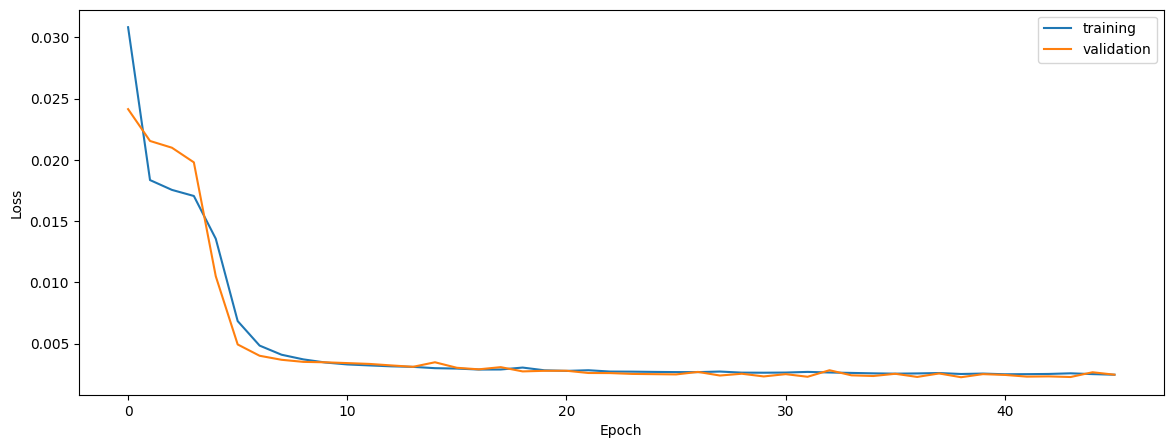

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.926803469418822
0.9490319291118677
0.9458007806656079


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.926803469418822
0.9490319291118677
0.9458007806656079


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9181420018656204
0.9389532613191472
0.9444165418407973


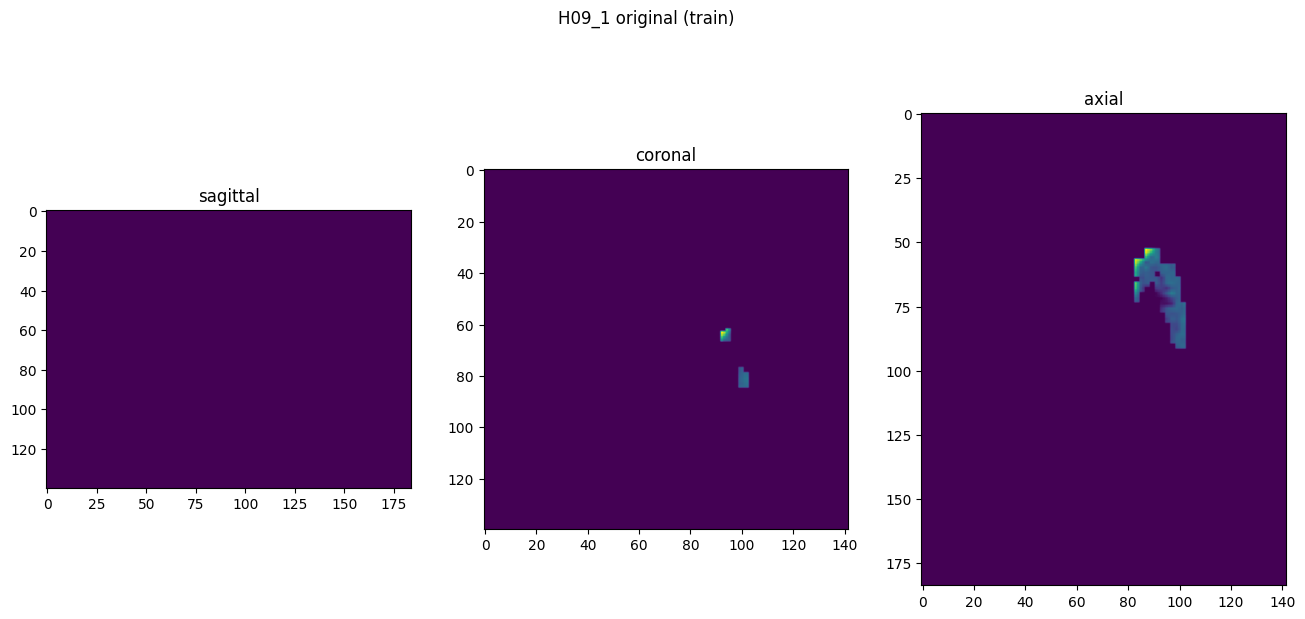

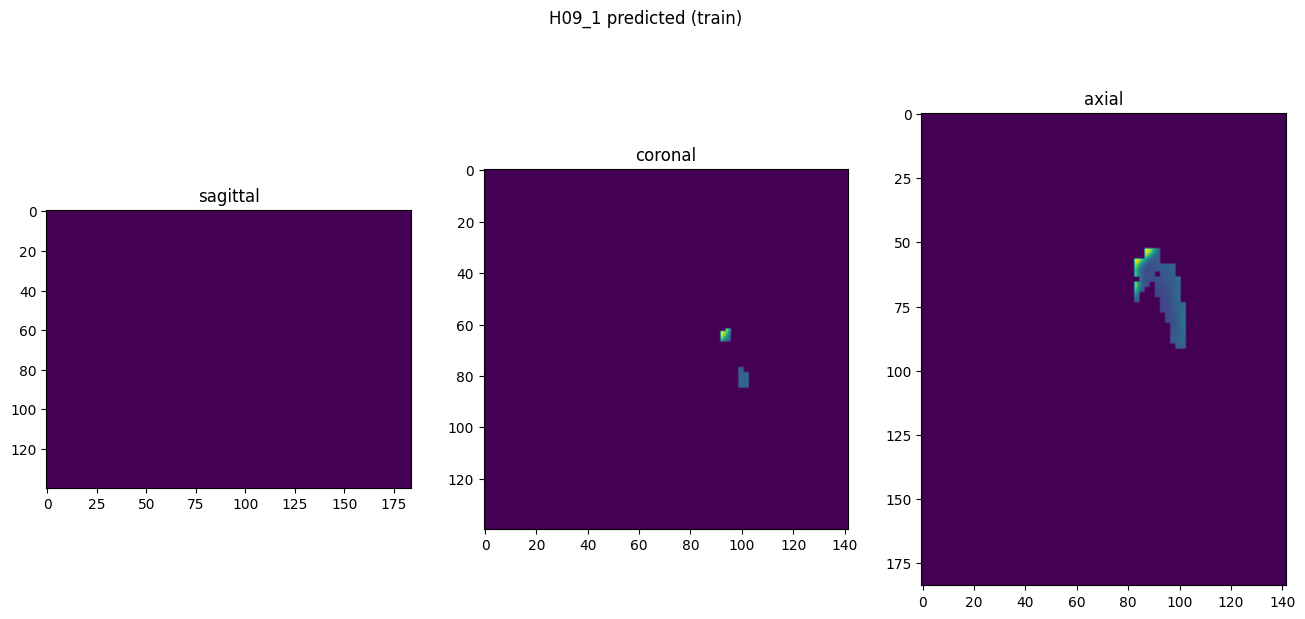

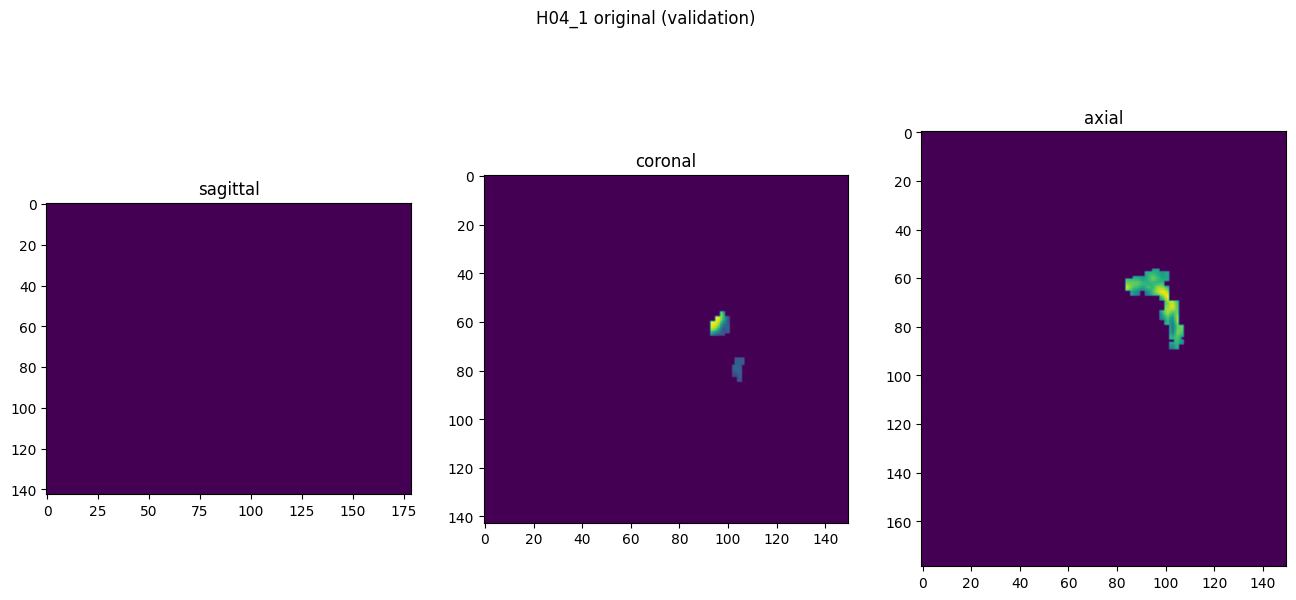

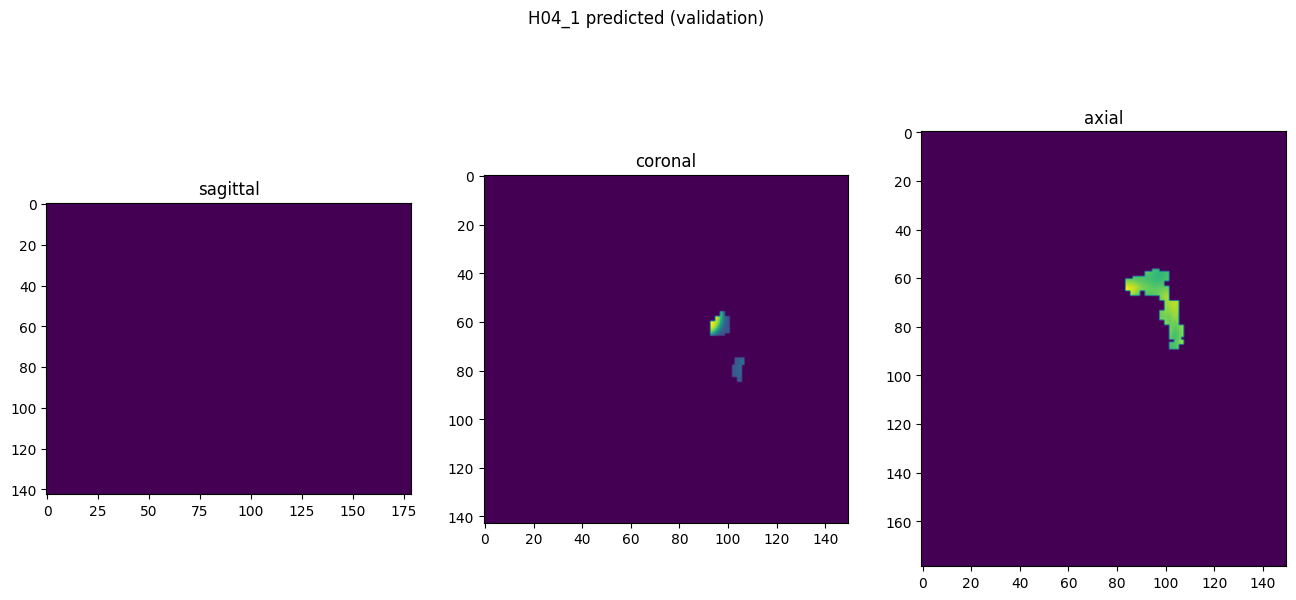

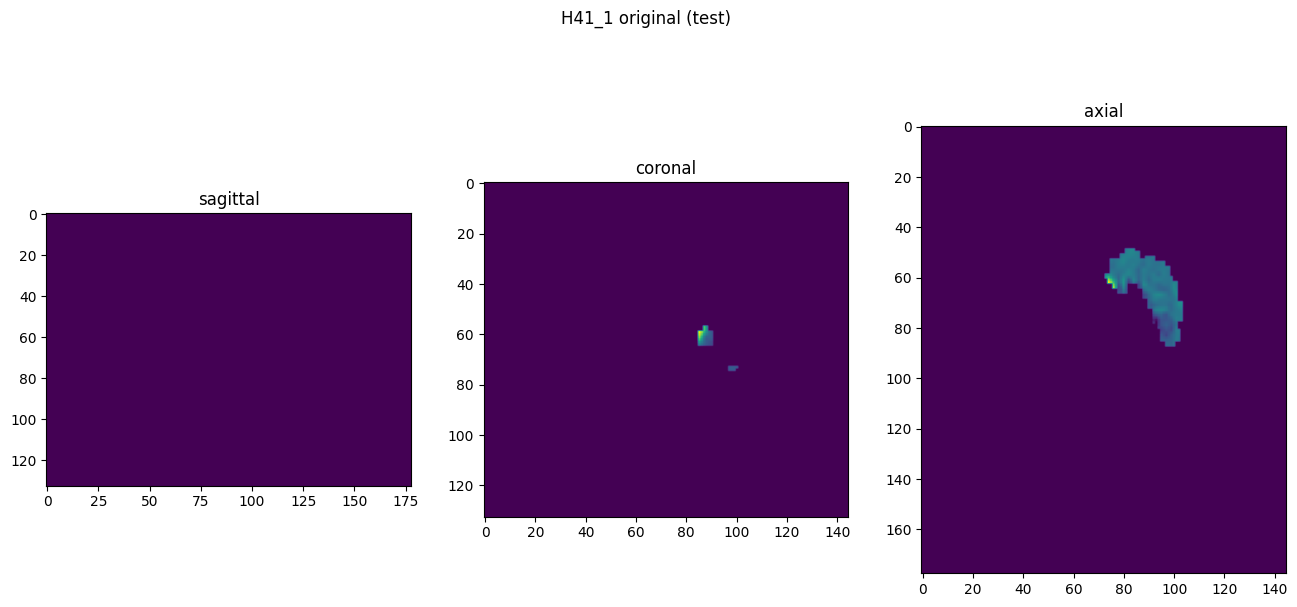

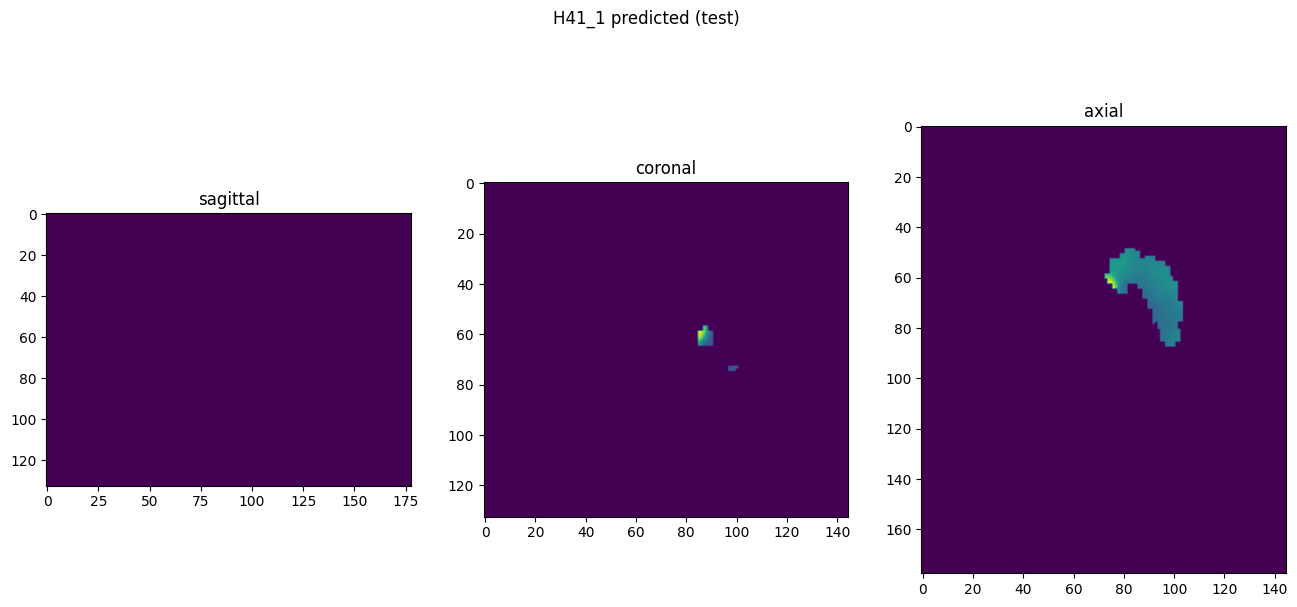

In [10]:
showResults(model, gen, threshold=None, background=False)